In [73]:
import os

# Read XML

xml_dir = '/root/projects/facemask-2/data/annotations'
xml_list = os.listdir(xml_dir)

In [74]:
import xmltodict
def read_all_xmls(xml_list, xml_dir):
    final_list = []
    for xml_file in xml_list:
        with open(os.path.join(xml_dir, xml_file), 'r') as f:
            xml_content = f.read()
            xml_dict = xmltodict.parse(xml_content)
            final_list.append(xml_dict)
    return final_list

In [75]:
all_data = read_all_xmls(xml_list, xml_dir)

In [76]:
mask_weared_incorrect_idx = []
with_mask_idx = []
without_mask_idx = []

for i in range(len(all_data)):
    obj = all_data[i]['annotation']['object']
    if isinstance(obj, dict):
        obj = [obj]   
    elif not isinstance(obj, list):
        continue

    for j in obj:
        # mask_weared_incorrect and != with_mask and != without_mask
        if isinstance(j, dict) and j.get('name') == 'mask_weared_incorrect' and all(k.get('name') != 'with_mask' for k in obj) and all(k.get('name') != 'without_mask' for k in obj):
            mask_weared_incorrect_idx.append(i)
        elif isinstance(j, dict) and j.get('name') == 'with_mask':
            with_mask_idx.append(i)
        elif isinstance(j, dict) and j.get('name') == 'without_mask' and all(k.get('name') != 'with_mask' for k in obj) and all(k.get('name') != 'mask_weared_incorrect' for k in obj):
            without_mask_idx.append(i)    
            break

In [77]:
len(mask_weared_incorrect_idx), len(with_mask_idx), len(without_mask_idx)

(21, 3232, 60)

In [78]:
from PIL import Image
import matplotlib.pyplot as plt

def display_img(img_path):

    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

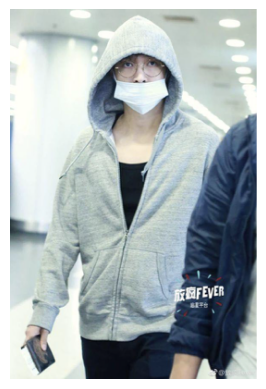

In [79]:
img_dir = '/root/projects/facemask-2/data/images/'
display_img(
    os.path.join(img_dir, all_data[mask_weared_incorrect_idx[20]]['annotation']['filename']
))

In [80]:
import cv2
import numpy as np
import os

def parse_annotation(data_dict, img_path):
    """
    Returns:
        img: loaded image (e.g., with cv2)
        boxes: list of [x_min, y_min, x_max, y_max] (Pascal VOC style)
        labels: list of str (class names)
    """
    img = cv2.imread(str(img_path))
    h, w, _ = img.shape

    annotation = data_dict["annotation"]
    obj = annotation["object"]
    if not isinstance(obj, list):
        obj = [obj]

    boxes, labels = [], []
    for o in obj:
        bbox = o["bndbox"]
        x_min = int(bbox["xmin"])
        y_min = int(bbox["ymin"])
        x_max = int(bbox["xmax"])
        y_max = int(bbox["ymax"])

        # clip to image size
        x_min = max(0, x_min)
        y_min = max(0, y_min)
        x_max = min(w, x_max)
        y_max = min(h, y_max)

        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(o["name"])

    return img, boxes, labels


In [81]:
def make_mosaic(indices, all_data, img_dir, mosaic_size=640):
    """
    Fixed version: properly handles resize + clip + degenerate box filtering
    """
    result = []
    for i in indices:
        img_fname = all_data[i]["annotation"]["filename"]
        img_path = os.path.join(img_dir, img_fname)
        img, boxes, labels = parse_annotation(all_data[i], img_path)

        # 1: resize to mosaic cell size
        old_h, old_w = img.shape[:2]
        img = cv2.resize(img, (mosaic_size, mosaic_size))

        # 2: transform each box to cell coords (640×640)
        cell_boxes = []
        cell_labels = []
        for box, label in zip(boxes, labels):
            x_min, y_min, x_max, y_max = box

            # scale from original image to 640×640 cell
            x_min = int(x_min * (mosaic_size / old_w))
            y_min = int(y_min * (mosaic_size / old_h))
            x_max = int(x_max * (mosaic_size / old_w))
            y_max = int(y_max * (mosaic_size / old_h))

            # CLIP to cell bounds (0, 640)
            x_min = max(0, min(mosaic_size, x_min))
            y_min = max(0, min(mosaic_size, y_min))
            x_max = max(0, min(mosaic_size, x_max))
            y_max = max(0, min(mosaic_size, y_max))

            # FILTER degenerate boxes (width/height <= 0)
            if x_max > x_min and y_max > y_min:
                cell_boxes.append([x_min, y_min, x_max, y_max])
                cell_labels.append(label)

        result.append((img, cell_boxes, cell_labels))

    # build 2×2 mosaic
    s = mosaic_size
    mosaic = np.full((2*s, 2*s, 3), 114, dtype=np.uint8)
    merged_boxes = []
    merged_labels = []

    # offsets: [top‑left, top‑right, bottom‑left, bottom‑right]
    for k, (img, boxes, labels) in enumerate(result):
        if k == 0:  # top left
            x1, y1, x2, y2 = 0, 0, s, s
        elif k == 1:  # top right
            x1, y1, x2, y2 = s, 0, 2*s, s
        elif k == 2:  # bottom left
            x1, y1, x2, y2 = 0, s, s, 2*s
        else:  # bottom right
            x1, y1, x2, y2 = s, s, 2*s, 2*s

        mosaic[y1:y2, x1:x2] = img

        # shift boxes to mosaic coordinates
        for box, label in zip(boxes, labels):
            x_min, y_min, x_max, y_max = box
            x_min += x1
            y_min += y1
            x_max += x1
            y_max += y1
            merged_boxes.append([x_min, y_min, x_max, y_max])
            merged_labels.append(label)

    return mosaic, merged_boxes, merged_labels


In [82]:
all_mask_weared_incorrect_data = [all_data[i] for i in mask_weared_incorrect_idx]
all_without_mask_data = [all_data[i] for i in without_mask_idx]

In [83]:
def save_mosaic_annotation(mosaic_dict, out_xml_path):
    # dict => XML string
    xml_str = xmltodict.unparse(mosaic_dict, pretty=True)

    # create dir if not exists
    os.makedirs(os.path.dirname(out_xml_path), exist_ok=True)
    # write to file
    with open(out_xml_path, "w") as f:
        f.write(xml_str)

In [84]:
img_dir = "/root/projects/facemask-2/data/images"
out_dir = "/root/projects/facemask-2/data/images"

os.makedirs(out_dir, exist_ok=True)

np.random.seed(42)

for _ in range(300):
    # pick 4 images, biasing minority class (e.g., mask_weared_incorrect)
    all_indices = list(range(len(all_mask_weared_incorrect_data)))
    chosen_idx = np.random.choice(all_indices, size=4, replace=True)

    mosaic_img, boxes, labels = make_mosaic(
        indices=chosen_idx,
        all_data=all_mask_weared_incorrect_data,
        img_dir=img_dir,
        mosaic_size=640
    )

    idx_to_save = _
    out_img_path = os.path.join(out_dir, f"mosaic_{idx_to_save}.jpg")
    cv2.imwrite(out_img_path, mosaic_img)

    # create annotation dict
    mosaic_dict = {
        "annotation": {
            "folder": "mosaic",
            "filename": f"mosaic_{idx_to_save}.jpg",
            "size": {
                "width": 640 * 2,
                "height": 640 * 2,
                "depth": 3,
            },
            "segmented": "0",
            "object": []
        }
    }

    obj_list = []
    for box, label in zip(boxes, labels):
        obj = {
            "name": label,
            "pose": "Unspecified",
            "truncated": "0",
            "occluded": "0",
            "difficult": "0",
            "bndbox": {
                "xmin": int(box[0]),
                "ymin": int(box[1]),
                "xmax": int(box[2]),
                "ymax": int(box[3]),
            }
        }
        obj_list.append(obj)

    mosaic_dict["annotation"]["object"] = obj_list

    out_xml = out_img_path.replace(".jpg", ".xml").replace('images', 'annotations')
    save_mosaic_annotation(mosaic_dict, out_xml)

In [85]:
img_dir = "/root/projects/facemask-2/data/images"
out_dir = "/root/projects/facemask-2/data/images"

os.makedirs(out_dir, exist_ok=True)

np.random.seed(42)

for _ in range(1000):
    # pick 4 images, biasing minority class (e.g., mask_weared_incorrect)
    all_indices = list(range(len(all_without_mask_data)))
    chosen_idx = np.random.choice(all_indices, size=4, replace=True)

    mosaic_img, boxes, labels = make_mosaic(
        indices=chosen_idx,
        all_data=all_without_mask_data,
        img_dir=img_dir,
        mosaic_size=640
    )

    idx_to_save = _ + 300
    out_img_path = os.path.join(out_dir, f"mosaic_{idx_to_save}.jpg")
    cv2.imwrite(out_img_path, mosaic_img)

    # create annotation dict
    mosaic_dict = {
        "annotation": {
            "folder": "mosaic",
            "filename": f"mosaic_{idx_to_save}.jpg",
            "size": {
                "width": 640 * 2,
                "height": 640 * 2,
                "depth": 3,
            },
            "segmented": "0",
            "object": []
        }
    }

    obj_list = []
    for box, label in zip(boxes, labels):
        obj = {
            "name": label,
            "pose": "Unspecified",
            "truncated": "0",
            "occluded": "0",
            "difficult": "0",
            "bndbox": {
                "xmin": int(box[0]),
                "ymin": int(box[1]),
                "xmax": int(box[2]),
                "ymax": int(box[3]),
            }
        }
        obj_list.append(obj)

    mosaic_dict["annotation"]["object"] = obj_list

    out_xml = out_img_path.replace(".jpg", ".xml").replace('images', 'annotations')
    save_mosaic_annotation(mosaic_dict, out_xml)

In [86]:
# try to plot the image and annotations
def plot_image_with_boxes(img_path, xml_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    annot = read_all_xmls([os.path.basename(xml_path)], os.path.dirname(xml_path))[0]
    boxes, labels = parse_annotation(annot, img_path)[1:]

    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(img, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis('off')


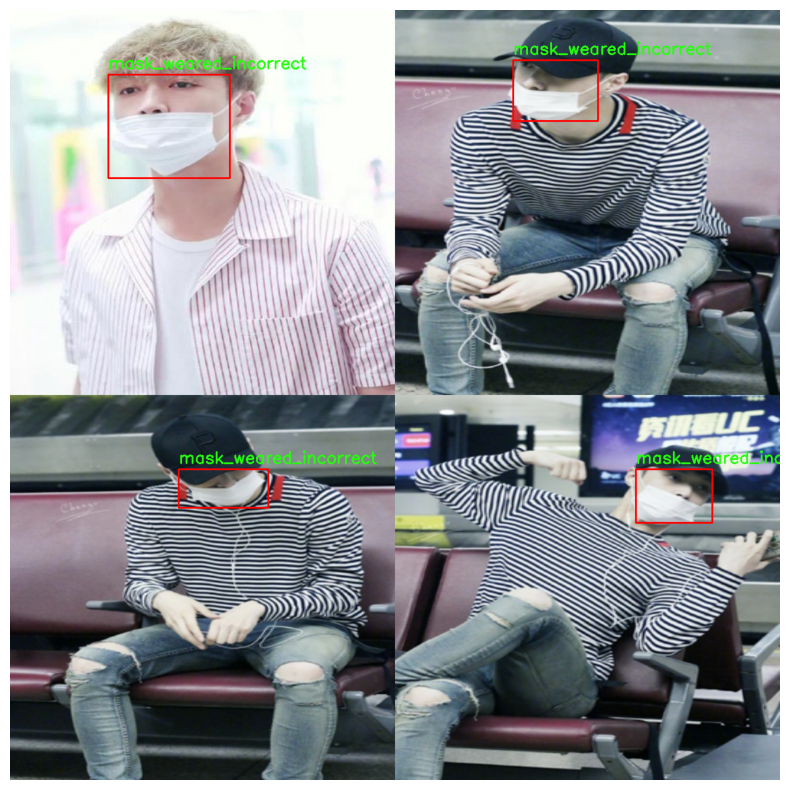

In [89]:
desired_idx = 200
img_path = os.path.join(out_dir, f"mosaic_{desired_idx}.jpg")
xml_path = os.path.join(out_dir.replace('images', 'annotations'), f"mosaic_{desired_idx}.xml")
plot_image_with_boxes(img_path, xml_path)

In [90]:
new_xml_dir = '/root/projects/facemask-2/data/annotations'
new_xml_list = os.listdir(new_xml_dir)

In [91]:
import xmltodict
def read_all_xmls(xml_list, xml_dir):
    final_list = []
    for xml_file in xml_list:
        with open(os.path.join(xml_dir, xml_file), 'r') as f:
            xml_content = f.read()
            xml_dict = xmltodict.parse(xml_content)
            final_list.append(xml_dict)
    return final_list

In [92]:
new_all_data = read_all_xmls(new_xml_list, new_xml_dir)

In [93]:
mask_weared_incorrect_idx = []
with_mask_idx = []
without_mask_idx = []

for i in range(len(new_all_data)):
    obj = new_all_data[i]['annotation']['object']
    if isinstance(obj, dict):
        obj = [obj]   
    elif not isinstance(obj, list):
        continue

    for j in obj:
        # mask_weared_incorrect and != with_mask and != without_mask
        if isinstance(j, dict) and j.get('name') == 'mask_weared_incorrect' and all(k.get('name') != 'with_mask' for k in obj) and all(k.get('name') != 'without_mask' for k in obj):
            mask_weared_incorrect_idx.append(i)
        elif isinstance(j, dict) and j.get('name') == 'with_mask':
            with_mask_idx.append(i)
        elif isinstance(j, dict) and j.get('name') == 'without_mask' and all(k.get('name') != 'with_mask' for k in obj) and all(k.get('name') != 'mask_weared_incorrect' for k in obj):
            without_mask_idx.append(i)    
            break

In [94]:
len(mask_weared_incorrect_idx), len(with_mask_idx), len(without_mask_idx)

(1221, 3232, 1060)